In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)



Mounted at /content/drive


In [6]:
# @title Imports Libraries and Tools
import os
import numpy as np
import random
from PIL import Image, ImageEnhance

#keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from sklearn.utils import shuffle


In [7]:
# @title Dataset
train_dir= '/content/drive/MyDrive/MRIimages/Training/'
test_dir= '/content/drive/MyDrive/MRIimages/Testing/'

train_paths = []
train_labels  = []
for label in os.listdir(train_dir):
  for image in os.listdir(os.path.join(train_dir,label)):
    train_paths.append(os.path.join(train_dir,label,image))
    train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

test_paths = []
test_labels  = []
for label in os.listdir(test_dir):
  for image in os.listdir(os.path.join(test_dir,label)):
    test_paths.append(os.path.join(test_dir,label,image))
    test_labels.append(label)

  test_paths, test_labels = shuffle(test_paths, test_labels)



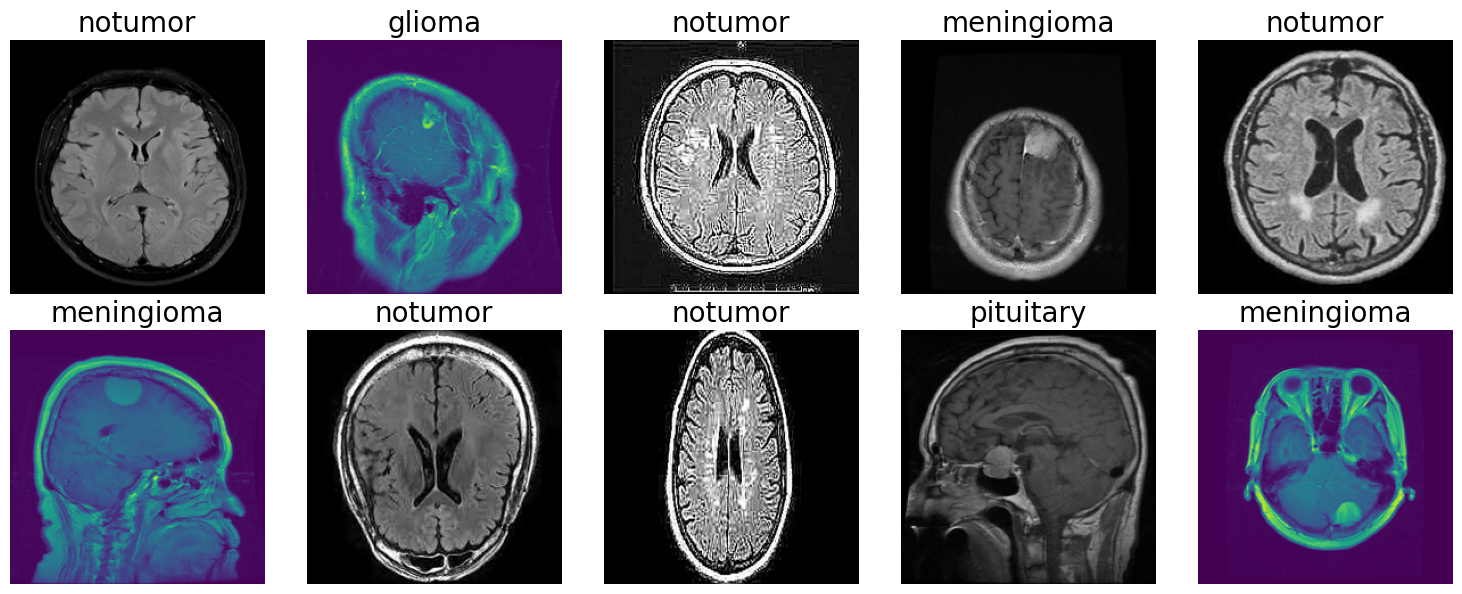

In [8]:
# @title Data Visualization

import random
import matplotlib.pyplot as plt

random_indices = random.sample(range(len(train_paths)), 10)


fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes= axes.ravel()

for i, index in enumerate(random_indices):
    image_path = train_paths[index]
    img= Image.open(image_path)
    img = img.resize((224, 224))
    axes[i].imshow(img)
    axes[i].set_title(train_labels[index], fontsize=20)
    axes[i].axis('off')

plt.tight_layout()
plt.show()


In [9]:
# @title Image Preprocessing
def augment_image(image):
  image = Image.fromarray(np.uint8(image))
  image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))
  image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))
  image = np.array(image)/255.0

  return image
def open_images(paths):
  images = []
  for path in paths:
    image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
    image = augment_image(image)
    images.append(image)

  return np.array(images)

def encode_labels(labels):
  unique_labels = os.listdir(train_dir)
  encoded = [unique_labels.index(label) for label in labels]
  return np.array(encoded)

def datagen(paths, labels, batch_size=12, epochs=1):
  for i in range(epochs):
    for j in range(0, len(paths), batch_size):
      batch_paths = paths[j:j+batch_size]
      batch_images = open_images(batch_paths)
      batch_labels = labels[j:j+batch_size]
      batch_labels = encode_labels(batch_labels)
      yield batch_images, batch_labels



In [10]:
# @title Model Architecture

IMAGE_SIZE=128
base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

for layer in base_model.layers:
  layer.trainable = False

base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

model = Sequential()
model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(os.listdir(train_dir)), activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

batch_size=20
steps = int(len(train_paths) / batch_size)
epochs = 5

history=model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),  epochs=epochs, steps_per_epoch=steps)

Epoch 1/5
287/287 ━━━━━━━━━━━━━━━━━━━━ 1763s 6s/step - loss: 0.6478 - sparse_categorical_accuracy: 0.7409
Epoch 2/5
287/287 ━━━━━━━━━━━━━━━━━━━━ 1182s 4s/step - loss: 0.2472 - sparse_categorical_accuracy: 0.9079
Epoch 3/5
287/287 ━━━━━━━━━━━━━━━━━━━━ 1178s 4s/step - loss: 0.1823 - sparse_categorical_accuracy: 0.9333
Epoch 4/5
287/287 ━━━━━━━━━━━━━━━━━━━━ 1170s 4s/step - loss: 0.1328 - sparse_categorical_accuracy: 0.9484
Epoch 5/5
287/287 ━━━━━━━━━━━━━━━━━━━━ 1163s 4s/step - loss: 0.0937 - sparse_categorical_accuracy: 0.9658


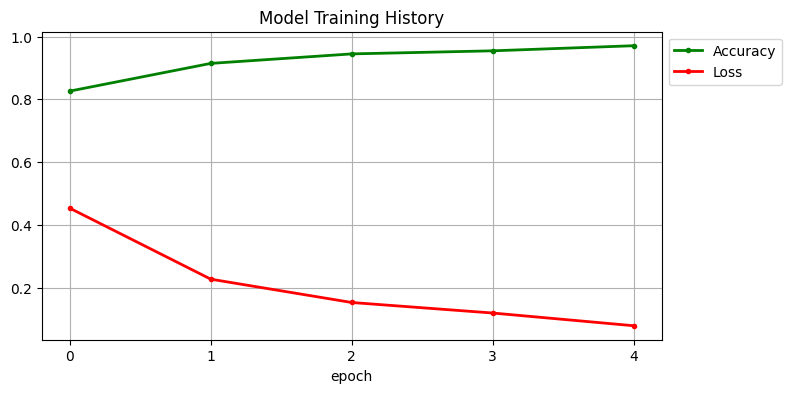

In [11]:
# @title Train and val plots
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import load_model
import numpy as np

# 1. Prediction on test data
test_images = open_images(test_paths)
test_labels_encoded = encode_labels(test_labels)

# Predict using the trained model
test_predictions = model.predict(test_images)

# 2. Classification Report
print("Classification Report:")
print(classification_report(test_labels_encoded, np.argmax(test_predictions, axis=1)))

41/41 ━━━━━━━━━━━━━━━━━━━━ 222s 5s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.77      0.87       300
           1       0.84      0.94      0.89       306
           2       0.97      0.98      0.98       300
           3       0.95      1.00      0.97       405

    accuracy                           0.93      1311
   macro avg       0.94      0.93      0.93      1311
weighted avg       0.94      0.93      0.93      1311



Confusion Matrix:
[[232  54   2  12]
 [  3 289   8   6]
 [  0   2 295   3]
 [  0   0   0 405]]


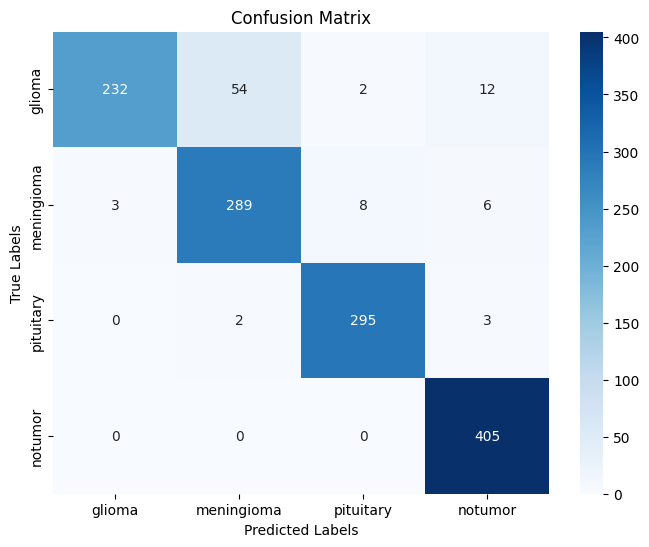

In [14]:
# @title Model Confusion Plot

conf_matrix = confusion_matrix(test_labels_encoded, np.argmax(test_predictions, axis=1))
print("Confusion Matrix:")
print(conf_matrix)

# Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=os.listdir(train_dir), yticklabels=os.listdir(train_dir))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

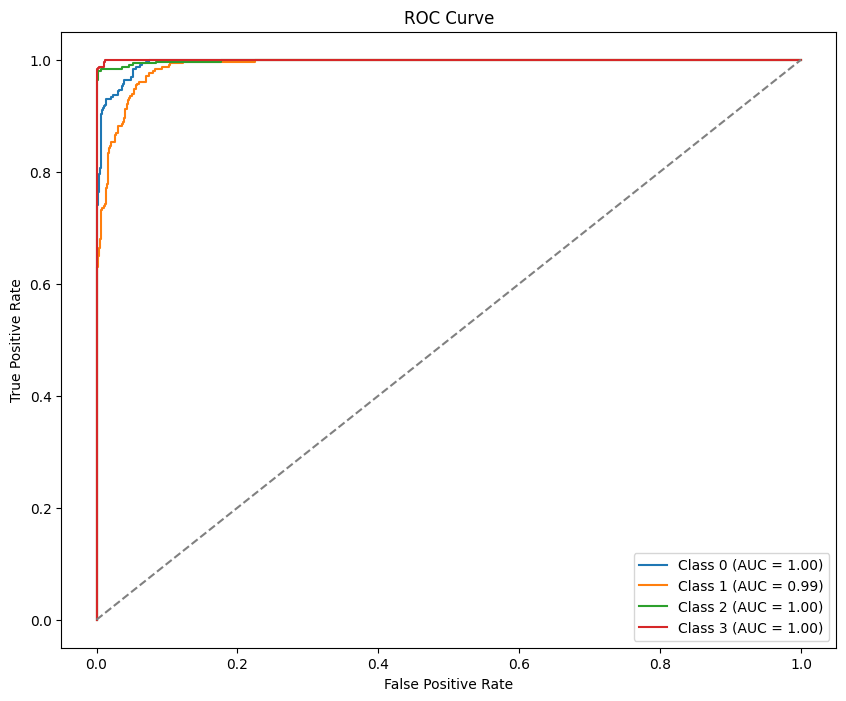

In [32]:
test_labels_bin = label_binarize(test_labels_encoded, classes=np.arange(len(os.listdir(train_dir))))
test_predictions_bin = test_predictions  # The predicted probabilities for each class


fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(os.listdir(train_dir))):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure(figsize=(10, 8))
for i in range(len(os.listdir(train_dir))):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

In [35]:
model.save_weights('model1.weights.h5')


In [36]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Flatten, Dropout, Dense
from tensorflow.keras.optimizers import Adam
import os

IMAGE_SIZE = 128

# Rebuild the same architecture
base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

for layer in base_model.layers:
    layer.trainable = False

# same 3 layers were made trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

model = Sequential([
    Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    base_model,
    Flatten(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(4, activation='softmax')  # assuming 4 classes
])

# compile to match original settings
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

# finally, load weights
model.load_weights('model1.weights.h5')


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 0 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [52]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Class labels
class_labels = ['glioma', 'meningioma', 'pituitary', 'notumor']


def detect_and_display(img_path, model, image_size=128):
    """
    Function to detect tumor and display results.
    If no tumor is detected, it displays "No Tumor".
    Otherwise, it shows the predicted tumor class and confidence.
    """
    try:
        # Load and preprocess the image
        img = load_img(img_path, target_size=(image_size, image_size))
        img_array = img_to_array(img) / 255.0  # Normalize pixel values
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Make a prediction
        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        confidence_score = np.max(predictions, axis=1)[0]

        # Determine the class
        if class_labels[predicted_class_index] == 'notumor':
            result = "No Tumor"
        else:
            result = f"Tumor: {class_labels[predicted_class_index]}"

        # Display the image with the prediction
        plt.imshow(load_img(img_path))
        plt.axis('off')
        plt.title(f"{result} (Confidence: {confidence_score * 100:.2f}%)")
        plt.show()

    except Exception as e:
        print("Error processing the image:", str(e))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


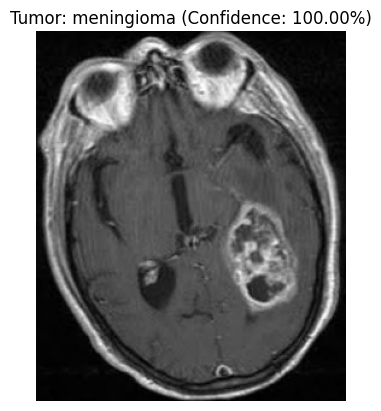

In [53]:
image_path = '/content/drive/MyDrive/MRIimages/Testing/meningioma/Te-meTr_0001.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


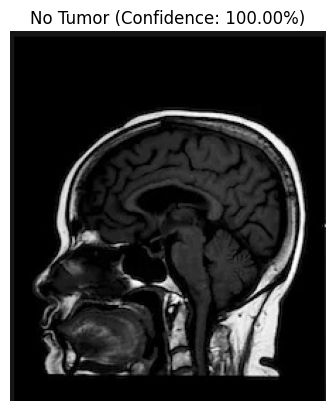

In [57]:
image_path = '/content/drive/MyDrive/MRIimages/Testing/notumor/Te-noTr_0004.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


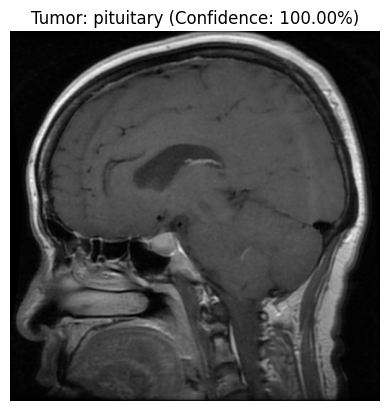

In [55]:
image_path = '/content/drive/MyDrive/MRIimages/Testing/pituitary/Te-piTr_0003.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


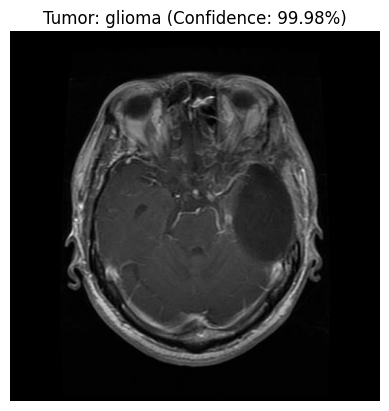

In [56]:
image_path = '/content/drive/MyDrive/MRIimages/Testing/glioma/Te-gl_0015.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)